# Exploring the Cherenkov process of high energy muons in H2O

The Frank-Tamm formula

$$ {\frac {d^{2}E}{dx\,d\omega }}={\frac {q^{2}}{4\pi }}\mu (\omega )\omega {\left(1-{\frac {c^{2}}{v^{2}n^{2}(\omega )}}\right)}$$

provided that $\beta ={\frac  {v}{c}}>{\frac  {1}{n(\omega )}}$. Here ${\mu (\omega )}$ and $n(\omega )$ are the frequency-dependent permeability and index of refraction of the medium respectively, $q$ is the electric charge of the particle, $v$ is the speed of the particle, and $c$ is the speed of light in vacuum.


Energy per unit length

$$ {\frac  {dE}{dx}}={\frac  {q^{2}}{4\pi }}\int _{{v>{\frac  {c}{n(\omega )}}}}\mu (\omega )\omega {\left(1-{\frac  {c^{2}}{v^{2}n^{2}(\omega )}}\right)}d\omega $$


Now say we have a ~GeV muon going through an Outer Detector/Shield at SNOLAB (~13 m of water). Can we approximate the losses due to the Cherenkov effect negligable?

In [1]:
import numpy as np
#from numpy.random import choice
import matplotlib.pyplot as plt
from numba import jit, njit, vectorize, jitclass, float64, int64, prange, cuda, guvectorize

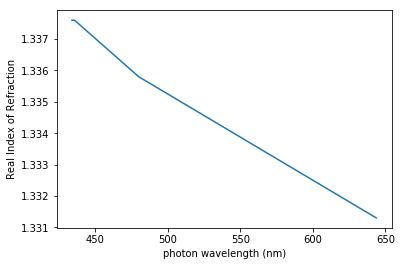

In [2]:
#In eV
energies = np.array([0.602, 0.689, 1.03,  1.926, 2.583, 2.845, 2.857, 3.124,3.457, 3.643, 3.812, 4.086, 4.511, 4.953, 5.474, 6.262, 7.000, 8.300, 10.00, 12.60])
#Refractive index
n = np.array([1.303, 1.3120,   1.3239,   1.3313, 1.3358, 1.3376, 1.3376, 1.3392, 1.3423, 1.3442, 1.3460, 1.3486, 1.3540, 1.3619, 1.3723, 1.3960, 1.3960, 1.3960,1.3960, 1.3960])

#plt.plot(energies, n)

wavelengths = 1239.8/energies

freq = 3e17/wavelengths

#Only take the ~near visible range (where photomultiplier tubes are sensitive). 
#This is the tail of the Cherenkov emission spectrum.
freq = freq[3:7]
wavelengths=wavelengths[3:7]
energies=energies[3:7]
n=n[3:7]

plt.plot(wavelengths, n)
plt.xlabel('photon wavelength (nm)')
plt.ylabel('Real Index of Refraction')


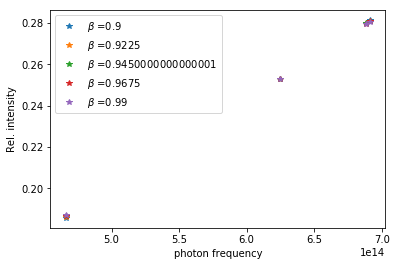

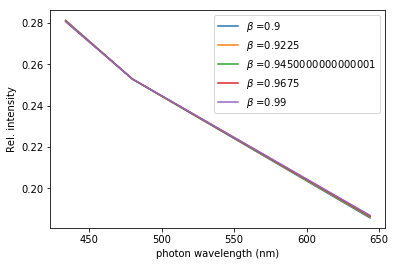

In [3]:
#I think mu(w) is constant in this range... So we can ignore the normalization then normalize later
b = np.linspace(0.9, 0.99, 5)



for beta in b:
    E_loss = 1.0/(4*np.pi) * freq*(1.0 - 1.0/(beta**2.0 * n**2.0))
    plt.plot(freq,E_loss/np.abs(E_loss.sum()), '*', label=r'$\beta$ ='+str(beta))
    
plt.xlabel('photon frequency')
plt.ylabel('Rel. intensity')
plt.legend()
plt.show()
for beta in b:
    E_loss = 1.0/(4*np.pi) * freq*(1.0 - 1.0/(beta**2.0 * n**2.0))
    plt.plot(wavelengths,E_loss/np.abs(E_loss.sum()), '-',label=r'$\beta$ ='+str(beta) )
    
plt.xlabel('photon wavelength (nm)')
plt.ylabel('Rel. intensity')
plt.legend()

In [4]:
#Checking to see if our generated Cherenkov spectrum looks right.
freqSample = []
freqDensSpan=np.linspace(freq[0], freq[-1], 1000)
freqDens = np.interp(freqDensSpan, freq, E_loss)
freqDens = freqDens/np.abs(freqDens.sum())

#for i in range(10000):
#    freqSample.append(np.random.choice(np.linspace(freqDensSpan[0],freqDensSpan[-1], len(freqDens)),p=freqDens))
    
#plt.hist(freqSample)

/home/soud/.local/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


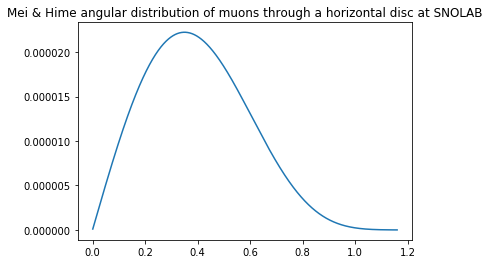

In [5]:
#Muon parameters/angular distribution

mwe_depth = 6010.0 #SNOlab
lambdaa = 825.0 #at 6000 mwe

lowlim = 1e-3
uplim = 1.16 #1 in 100,000 chance a muon will come in at steeper angle than this.
npoints = 100000
thetarad=np.linspace(lowlim, uplim, npoints)

MeiHime= np.cos(thetarad)*np.sin(thetarad)*( (8.60*1e-6)*np.exp(-(mwe_depth/1000)/(0.45*np.cos(thetarad)))+ (0.44*1e-6)*np.exp(-(mwe_depth/1000.0)/(0.87*np.cos(thetarad))) )/np.cos(thetarad)
MeiHime = MeiHime /np.sqrt(MeiHime.sum()**2.0)

plt.plot(thetarad, MeiHime)
plt.title('Mei & Hime angular distribution of muons through a horizontal disc at SNOLAB')
plt.legend()


# And now we dance...

Set up the simulation...

In [6]:
#Simulation stuff
GenDiscRad = 3200.0 #generation disc radius
GenDiscHeight = 2300.0 #generation disc height

ODradius = 655.0 #Water tank radius
ODheight = 1402.0 #water tank height (centered at zero)
OCradius = 223.0 #outer spherical cryostat radius

#For now, select photon energy angle etc... here.
thetaRel = 0.733 #radians, approx Cherenkov angle in optical (~0.5 degree precision)
frequency = 6.25e14

#Define custom data type here for particle
ptcl = np.dtype({'names':['x', 'y', 'z', 'px', 'py', 'pz', 'tracklength'], 
                 'formats':[np.double, np.double, np.double, np.double, np.double, np.double, np.double]})


ptcls = np.array([1,2,3,4,5,6], dtype=ptcl)
mutest = np.zeros(3,dtype=ptcl)

mutest['px'], mutest['py'] = 20.0, 10.0

print(mutest)

@vectorize([float64(float64, float64)], target='parallel', nopython=True)
def f(x, y):
    return x + y


@guvectorize([(int64[:], int64, int64[:])], '(n),()->(n)', target='parallel', nopython=True)
def g(x, y, res):
    for i in range(x.shape[0]):
        res[i] = x[i] + y

%timeit f(np.ones(10000, dtype=np.int64),np.ones(10000, dtype=np.int64)*2)[0]

[(0., 0., 0., 20., 10., 0., 0.) (0., 0., 0., 20., 10., 0., 0.)
 (0., 0., 0., 20., 10., 0., 0.)]
10000 loops, best of 3: 79.4 µs per loop


In [130]:
## @vectorize('[bool(float64, float64, float64, float64, float64, float64)]')
#@njit
def calc_intersect_disc(particle, height, radius):
    t = (height - particle['z'])/particle['pz'] #z_pos + p_z*t = height
    x_new = particle['x']+particle['px']*t 
    y_new = particle['y']+particle['py']*t
    if( (x_new*x_new + y_new*y_new < radius*radius) and t>=0.):
        return np.array([x_new, y_new, particle['z']+particle['pz']*t]) #intersection point
    else:
        return False


#@vectorize('[bool(float64, float64, float64, float64, float64, float64)]')
def calc_intersect_wall(particle): #cylinder walls
    
    #a = mom[0]*mom[0] + mom[1]*mom[1]
    #b = 2.0*(pos[0]*mom[0]+pos[1]*mom[1])
    #c = pos[0]*pos[0] + pos[1]*pos[1] - ODradius*ODradius
    a = particle['px']*particle['px'] + particle['py']*particle['py']
    b = 2.0*(particle['x']*particle['px']+particle['y']*particle['py'])
    c = particle['x']*particle['x'] + particle['y']*particle['y']- ODradius*ODradius
    discriminant = b*b - 4.0*a*c
    
    if (discriminant<0): #doesn't intersect cylinder walls
        return False
  
    #Solve quadratic equation for t+-, if these yield intersections inside z range, keep
    t_pl = (-b + np.sqrt(discriminant))/(2.0*a)
    t_min = (-b - np.sqrt(discriminant))/(2.0*a)
    
    if(t_min<=0 and t_pl <=0):
        return False
    
    if (-ODheight/2.0<particle['z']<ODheight/2.0): #particle inside OD, take positive solution
        if(t_min>=0): #forward in time always
            x_new = particle['x']+particle['px']*t_min 
            y_new = particle['y']+particle['py']*t_min
            z_new = particle['z']+particle['pz']*t_min
            return np.array([x_new, y_new, z_new])
        elif(t_pl>0): #unnecessary but safe
            x_new = particle['x']+particle['px']*t_pl 
            y_new = particle['y']+particle['py']*t_pl
            z_new = particle['z']+particle['pz']*t_pl
            return np.array([x_new, y_new, z_new])
        else:
            return False
    
    #Cases for outside OD.
    z_new_min = particle['z']+t_min*particle['pz']
    z_new_pl = particle['z']+t_pl*particle['pz']
        
    if (t_min>=0 and t_pl>=0): # forward in time
        if((-ODheight/2.0<z_new_min<ODheight/2.0) and (-ODheight/2.0<z_new_pl<ODheight/2.0)):
            x_new = particle['x']+particle['px']*t_min
            y_new = particle['y']+particle['py']*t_min
            z_new = particle['z']+particle['pz']*t_min
            entry = np.array([x_new, y_new, z_new])
            particle['x'], particle['y'], particle['z'] = entry[0], entry[1], entry[2]

            x_new = particle['x']+particle['px']*t_pl
            y_new = particle['y']+particle['py']*t_pl
            z_new = particle['z']+particle['pz']*t_pl
            exit = np.array([x_new, y_new, z_new])
            #particle['tracklength']=np.sqrt(np.dot(entry-exit))
            return entry, exit
        
    if(t_min>=0 and (-ODheight/2.0<z_new_min<ODheight/2.0)):
        x_new = particle['x']+particle['px']*t_min 
        y_new = particle['y']+particle['py']*t_min
        return np.array([x_new, y_new, z_new_min])
    if(t_pl>=0 and (-ODheight/2.0<z_new_pl<ODheight/2.0)): #forward in time
        x_new = particle['x']+particle['px']*t_pl 
        y_new = particle['y']+particle['py']*t_pl
        return np.array([x_new, y_new, z_new_pl])

    return False
    

def calc_intersect_OD2(particle): #Make use of quadratic equations and be more efficient
    
    
    
    entry_set, exit_set = False, False
    
    outside_start = particle['z']>ODheight/2. #particle is above OD
    
    if(outside_start == False): #photon etc...created inside OD.
        if particle['pz']<0:
            floor_intersect = calc_intersect_disc(particle, -ODheight/2., ODradius)
        if particle['pz']>0:
            roof_intersect = calc_intersect_disc(particle, ODheight/2., ODradius)
        if(type(floor_intersect) != bool):
            return floor_intersect
        if(type(roof_intersect) != bool):
            return roof_intersect
        else: #photon hits wall somewhere
            return calc_intersect_wall(particle)
                

    if(outside_start):#check roof/floor first as these are fast
        #print("1")

        roof_intersect = calc_intersect_disc(particle, ODheight/2., ODradius)
        floor_intersect = calc_intersect_disc(particle, -ODheight/2., ODradius)
        
        if((particle['x']*particle['x'] + particle['y']*particle['y'] - ODradius*ODradius)<=0 and type(roof_intersect)==bool): #within radius upon start
            #print("2")
            return False #Can't intersect cylinder if misses roof in this case 
        
        elif(type(roof_intersect)!=bool):#hits roof
            entry = roof_intersect
            particle['x'], particle['y'], particle['z'] = entry[0], entry[1], entry[2]
            entry_set = True
            #print("roof")
            if(type(floor_intersect) != bool): #entered roof, exitted floor
                #print("roof and floor")
                particle['x'], particle['y'], particle['z'] = entry[0], entry[1], entry[2]
                return entry, floor_intersect #we are done! Lucky.
            else:#entered roof, exits wall
                #print("roof and wall")
                particle['x'], particle['y'], particle['z'] = entry[0], entry[1], entry[2]
                exit = calc_intersect_wall(particle)
                #particle['tracklength']=np.sqrt(np.dot(entry-exit))
                return entry, exit
                       
        elif(type(floor_intersect) != bool and type(roof_intersect)==bool): #didn't enter roof, but did exit floor
            exit = floor_intersect
            exit_set = True
            #print("wall and floor")
            #print(calc_intersect_wall(pos,mom), exit)
            if(type(calc_intersect_wall(particle)) == bool):
                return False
            #Now there's only one option, it entered through the walls
            entry = calc_intersect_wall(particle)
            particle['x'], particle['y'], particle['z'] = entry[0], entry[1], entry[2]
            #particle['tracklength']=np.sqrt(np.dot(entry-exit))

            return entry, exit
        else:#Only other option, it entered and exitted via the walls or missed the entire thing
            #print("7")
            #print(calc_intersect_wall(pos, mom))
            return calc_intersect_wall(particle)
        
def calc_intersect_OD_photon(particle): #Make use of quadratic equations and be more efficient
    
    roof_intersect = calc_intersect_disc(particle, ODheight/2., ODradius)
    floor_intersect = calc_intersect_disc(particle, -ODheight/2., ODradius)

    if(type(roof_intersect)!=bool):#hits roof
        #print("roof")
        hit = roof_intersect
        particle['x'], particle['y'], particle['z'] = hit[0], hit[1], hit[2]
        return hit
    elif(type(floor_intersect) != bool): #entered roof, exitted floor
        #print("floor")
        hit = floor_intersect
        particle['x'], particle['y'], particle['z'] = hit[0], hit[1], hit[2]
        return hit
    else:#entered roof, exits wall
        #print("wall")
        hit = calc_intersect_wall(particle)
        particle['x'], particle['y'], particle['z'] = hit[0], hit[1], hit[2]
        #particle['tracklength']=np.sqrt(np.dot(entry-exit))
        return hit


        
#For photons we know they are created inside the OD so... JIT it!
@njit
def calc_intersect_disc_photon(particle, height, radius):
    t = (height - particle['z'])/particle['pz'] #z_pos + p_z*t = height
    x_new = particle['x']+particle['px']*t 
    y_new = particle['y']+particle['py']*t
    if( (x_new*x_new + y_new*y_new < radius*radius) and t>=0.):
        return np.array([x_new, y_new, particle['z']+particle['pz']*t]) #intersection point
    else:
        return np.zeros(3)
    
@njit
def calc_intersect_wall_photon(particle): #cylinder walls
    a = particle['px']*particle['px'] + particle['py']*particle['py']
    b = 2.0*(particle['x']*particle['px']+particle['y']*particle['py'])
    c = particle['x']*particle['x'] + particle['y']*particle['y']- ODradius*ODradius
    discriminant = b*b - 4.0*a*c
    
    if (discriminant<0): #doesn't intersect cylinder walls
        return np.zeros(3)
  
    #Solve quadratic equation for t+-, if these yield intersections inside z range, keep
    t_pl = (-b + np.sqrt(discriminant))/(2.0*a)
    t_min = (-b - np.sqrt(discriminant))/(2.0*a)
    
    if(t_min<=0 and t_pl <=0):
        return False
    
    if (-ODheight/2.0<particle['z']<ODheight/2.0): #particle inside OD, take positive solution
        if(t_min>=0): #forward in time always
            x_new = particle['x']+particle['px']*t_min 
            y_new = particle['y']+particle['py']*t_min
            z_new = particle['z']+particle['pz']*t_min
            return np.array([x_new, y_new, z_new])
        elif(t_pl>0): #unnecessary but safe
            x_new = particle['x']+particle['px']*t_pl 
            y_new = particle['y']+particle['py']*t_pl
            z_new = particle['z']+particle['pz']*t_pl
            return np.array([x_new, y_new, z_new])
        else:
            return np.zeros(3)

In [154]:
'''
Here we have the functions that actually create the particles
MakeMuon gives us a muon with the proper angles etc... 

MakeCherenkovPhoton takes in a position and momentum of a high energy muon 
and then creates a photon with the correct angles
'''

@njit
def rand_choice_nb(arr, prob):
    """
    :param arr: A 1D numpy array of values to sample from.
    :param prob: A 1D numpy array of probabilities for the given samples.
    :return: A random sample from the given array with a given probability.
    """
    return arr[np.searchsorted(np.cumsum(prob), np.random.random(), side="right")]

@njit
def MakeMuons(numMuons):
    muons = np.zeros(numMuons, dtype=ptcl)
    
    for i in prange(muons.shape[0]):
        #theta = np.random.choice(np.linspace(thetarad[0],thetarad[-1], len(MeiHime)),p=MeiHime)
        theta=rand_choice_nb(np.linspace(thetarad[0],thetarad[-1], len(MeiHime)), MeiHime)
        #theta = np.random.choice(np.linspace(thetarad[0],thetarad[-1], len(MeiHime)))
        phi = np.random.sample()*np.pi*2.0 #Random number in [0,2pi]

        r = np.sqrt(np.random.sample())*GenDiscRad #radius to generate particle on disc
        muons[i]['x']=np.sin(phi)*r#x position set by sin
        muons[i]['y']=np.cos(phi)*r #y position
        muons[i]['z'] = GenDiscHeight
        #print(self.position)
        momentum = np.array([-muons[i]['x'], -muons[i]['y'], 0.],dtype=np.double)
        momentum = momentum/np.sqrt(np.dot(momentum,momentum)) #normalize

        #If above OD directly
        if((muons[i]['x']*muons[i]['x'] + muons[i]['y']*muons[i]['y'])<=ODradius*ODradius):
            phi_smear= np.random.sample()*2.0*np.pi
        else:
            #smear randomly (but face OD in XY plane)
            phi_smear = np.arctan(ODradius/np.sqrt(muons[i]['x']*muons[i]['x'] + muons[i]['y']*muons[i]['y']))*(2.0*np.random.sample()-1.0)

        c, s = np.cos(phi_smear), np.sin(phi_smear)
        ux, uy, uz = [0.,0.,1.0] #Need to rotate around z axis 
        #Rotation matrix, note is it counterclockwise if axis is facing you
        R = np.array([[c+ux*ux*(1.0-c), ux*uy*(1-c) - uz*s, ux*uz*(1-c) + uy*s], [uy*ux*(1-c)+uz*s, c+uy*uy *(1-c), uy*uz*(1-c)-ux*s], [uz*ux*(1-c) - uy*s, uz*uy*(1-c)+ux*s, c+uz*uz * (1-c) ]])#rotation matrix
        momentum = R.dot(momentum) #rotated momentum
        #rotate it downwards now by the amount theta (following muon angular distribution)
        #i.e. about the axis p cross z (axis out of page/into page)
        ux, uy, uz = np.cross([0,0,1], momentum)
        rotateDown = np.pi/2.0 - theta
        c, s = np.cos(rotateDown), np.sin(rotateDown)
        R = np.array([[c+ux*ux*(1.0-c), ux*uy*(1-c) - uz*s, ux*uz*(1-c) + uy*s], [uy*ux*(1-c)+uz*s, c+uy*uy *(1-c), uy*uz*(1-c)-ux*s], [uz*ux*(1-c) - uy*s, uz*uy*(1-c)+ux*s, c+uz*uz * (1-c) ]])#rotation matrix
        momentum = R.dot(momentum)

        muons[i]['px'], muons[i]['py'],muons[i]['pz'] = momentum[0], momentum[1], momentum[2]
    return muons



numEvents = 20
#%timeit MakeMuons(numEvents)

muons=MakeMuons(numEvents)
#print(muons)
i=0
j=0
for mu in muons:
    if type(calc_intersect_OD2(mu))!=bool:
        i+=1
    if mu['z']!=2300.: #Only keep ones that enter the water tank, change their position to where they enter
        j+=1
print(i,j)
mask = muons['z']!=2300.
#MakeCherenkovPhoton(muons[mask][0])
    


(12, 12)


In [218]:
#Need to write new function without python, which will propagate the light in the water
#It will take in the array of muons which enter the OD, generate photons according to Cherenkov 
#physics all along their tracks
#Return a lightmap of where the photons intersected the wall/floor/roof

#@njit
def propagateChere(parentPtcl):
        
    parentMomentum = np.array([parentPtcl['px'], parentPtcl['py'], parentPtcl['pz']])
    parentEntryPosition = np.array([parentPtcl['x'], parentPtcl['y'], parentPtcl['z']])
    parentEndPosition = calc_intersect_OD_photon(parentPtcl)
    trackLength = np.sqrt(np.dot(parentEndPosition - parentEntryPosition,parentEndPosition - parentEntryPosition))
    
    photonsPerCm=100
    numPhotons = int(trackLength*photonsPerCm)
    
    photons = np.zeros(numPhotons,dtype=ptcl) #output array of photons

    
    for i in range(numPhotons):
        numStepsAway = np.random.rand()*trackLength #pick a random point on the track
        
        #photon position
        photons[i]['x']=parentEntryPosition[0]+numStepsAway*parentPtcl['px'] 
        photons[i]['y']=  parentEntryPosition[1]+numStepsAway*parentPtcl['py']
        photons[i]['z'] = parentEntryPosition[2]+numStepsAway*parentPtcl['pz']

        momentum=np.array([parentPtcl['px'], parentPtcl['py'], parentPtcl['pz']])

        #First, rotate relative to z axis by Cherenkov angle
        c, s = np.cos(thetaRel), np.sin(thetaRel) #cos and sine
        ux, uy, uz = np.cross(parentMomentum, [0.,0.,1.0]) #Need to rotate around axis out of page/into page
        R = np.array([[c+ux*ux*(1.0-c), ux*uy*(1-c) - uz*s, ux*uz*(1-c) + uy*s], [uy*ux*(1-c)+uz*s, c+uy*uy *(1-c), uy*uz*(1-c)-ux*s], [uz*ux*(1-c) - uy*s, uz*uy*(1-c)+ux*s, c+uz*uz * (1-c) ]])#rotation matrix
        momentum = R.dot(momentum)
        #momentum= np.dot(R, momentum)

        #Now rotate random amount of phi about axis of parent trajectory
        phi=np.random.sample()*np.pi*2.0
        c, s = np.cos(phi), np.sin(phi) #cos and sine
        ux, uy, uz = parentPtcl['px'], parentPtcl['py'], parentPtcl['pz']
        R = np.array([[c+ux*ux*(1.0-c), ux*uy*(1-c) - uz*s, ux*uz*(1-c) + uy*s], [uy*ux*(1-c)+uz*s, c+uy*uy *(1-c), uy*uz*(1-c)-ux*s], [uz*ux*(1-c) - uy*s, uz*uy*(1-c)+ux*s, c+uz*uz * (1-c) ]])#rotation matrix
        momentum = R.dot(momentum)
        
        photons[i]['px'], photons[i]['py'], photons[i]['pz'] = momentum[0], momentum[1], momentum[2]
    
        #Deal with the intersection/photon hit here
        calc_intersect_OD_photon(photons[i])
        i+=1
        
    #Return the hit positions
    return photons




#Iterate through those muons that make it into the water tank. 
#Produce Cherenkov light distributions

muonsInWater = muons[mask]
eventNumber = 2
photons1 = propagateChere(muonsInWater[eventNumber])
print("Number of photons in event: "+repr(photons1.size))

track=[]
scale = -500

#for i in range(1000):
#    track.append(np.array([muonsInWater[eventNumber]['x']-scale*i*muonsInWater[eventNumber]['px'], muonsInWater[eventNumber]['y']-scale*i*muonsInWater[eventNumber]['py'], muonsInWater[eventNumber]['z']-scale*i*muonsInWater[eventNumber]['pz']]))

    
#print(track)

from mpl_toolkits.mplot3d import axes3d
%matplotlib notebook

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, axisbg="1.0")
ax = fig.gca(projection='3d')
ax.scatter(photons1['x'],photons1['y'],photons1['z'], label='Photons', alpha=0.1, s=0.5, lw=0)
ax.quiver(muonsInWater[eventNumber]['x'],muonsInWater[eventNumber]['y'],muonsInWater[eventNumber]['z'],muonsInWater[eventNumber]['px']*scale,muonsInWater[eventNumber]['py']*scale,muonsInWater[eventNumber]['pz']*scale,color='orange', label='Muon track')
#ax.scatter(track[:][0],track[:][1],track[:][2], label='Muon Track', alpha=0.9, s=0.5)
ax.set_xlabel('X (cm)')
ax.set_ylabel('Y (cm)')
ax.set_zlabel('Z (cm)')
plt.legend()
plt.show()
plt.ion()
plt.savefig("ExampleLightMap.pdf")

Number of photons in event: 143768


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


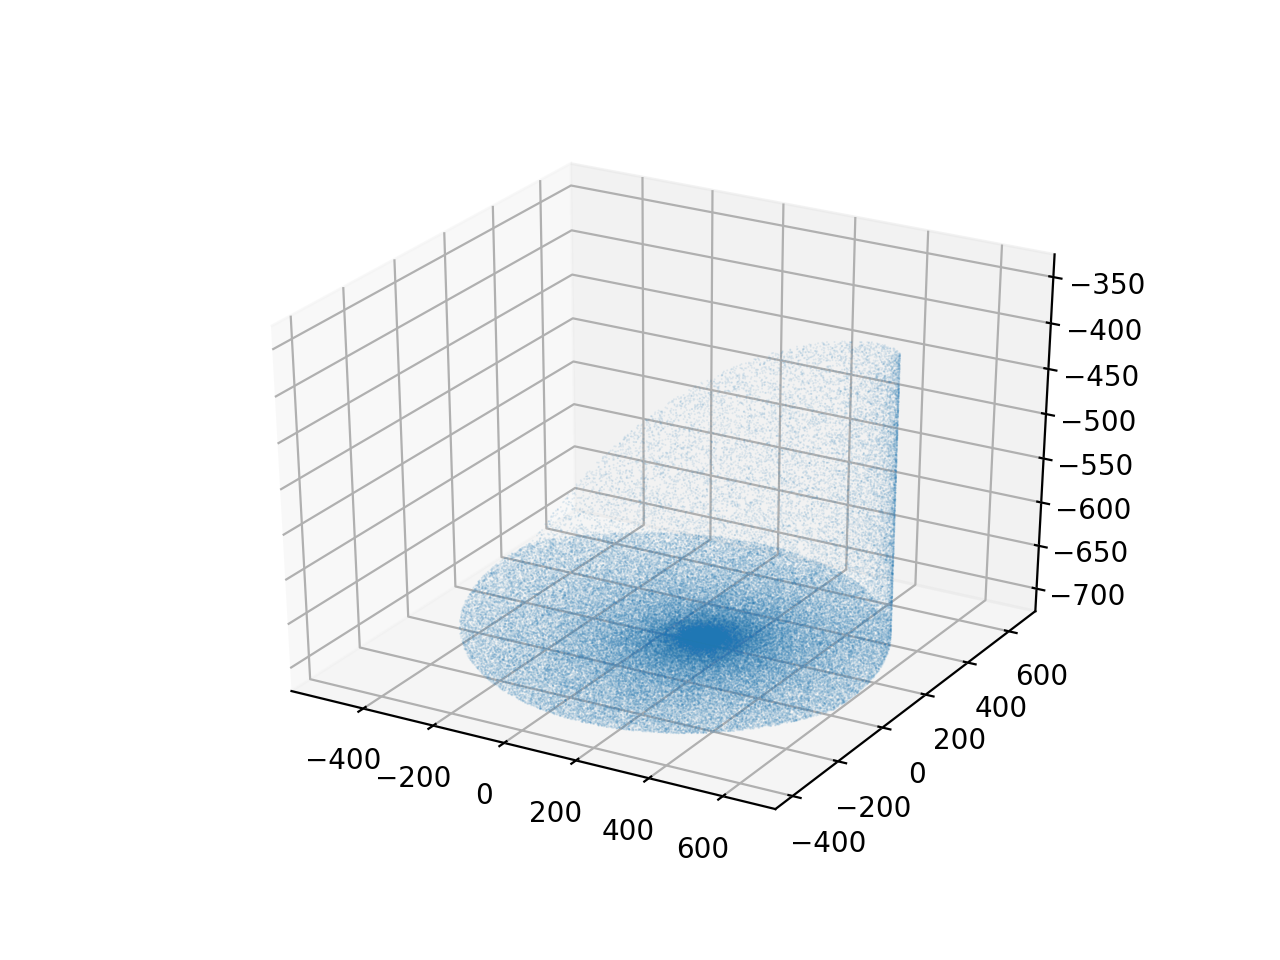

'\n#Let\'s check out a light map!\nfig = plt.figure()\nax = fig.add_subplot(1, 1, 1, axisbg="1.0")\nax = fig.gca(projection=\'3d\')\nax.scatter(lightMap[\'x\'],lightMap[\'y\'],lightMap[\'z\'], label=\'Photons\', alpha=0.6, s=0.5)\nax.scatter(muonsInWater[\'x\'],muonsInWater[\'y\'],muonsInWater[\'z\'], label=\'Muon Entry Points\', alpha=0.6, s=0.5)\nax.set_xlabel(\'X (cm)\')\nax.set_ylabel(\'Y (cm)\')\nax.set_zlabel(\'Z (cm)\')\nplt.legend()\nplt.show()\nplt.ion()\n'

In [214]:
#for i in range()


from mpl_toolkits.mplot3d import Axes3D
x,y,z = photons1['x'],photons1['y'],photons1['z']
xyz = np.vstack([x,y,z])

fig = plt.figure()
ax = fig.gca(projection='3d')
#ax.scatter(x, y, z, c=z, cmap='viridis')
ax.scatter(x,y,z, lw=0, s=0.5,alpha=0.1)
# Add a color bar which maps values to colors.
#fig.colorbar(shrink=0.5, aspect=5)
plt.show()

'''
#Let's check out a light map!
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, axisbg="1.0")
ax = fig.gca(projection='3d')
ax.scatter(lightMap['x'],lightMap['y'],lightMap['z'], label='Photons', alpha=0.6, s=0.5)
ax.scatter(muonsInWater['x'],muonsInWater['y'],muonsInWater['z'], label='Muon Entry Points', alpha=0.6, s=0.5)
ax.set_xlabel('X (cm)')
ax.set_ylabel('Y (cm)')
ax.set_zlabel('Z (cm)')
plt.legend()
plt.show()
plt.ion()
'''